In [1]:
import pandas as pd
import numpy as np
import os
from glob import glob
import itertools
import fnmatch
import random
import matplotlib.pylab as plt
import seaborn as sns
import cv2
import imageio
import sklearn
from sklearn import model_selection
from sklearn.model_selection import train_test_split, KFold, cross_val_score, StratifiedKFold, learning_curve, GridSearchCV
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import keras
from keras import backend as K
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential, model_from_json
from keras.optimizers import SGD, RMSprop, Adam, Adagrad, Adadelta
from keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPool2D, MaxPooling2D
%matplotlib inline

C:\Users\mezom\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
import glob
# Adjust the path to where your images are stored on your laptop
imagePatches = glob.glob('D:/year_3/sem_2/Neural Networks/project/data/**/*.png', recursive=True)
for filename in imagePatches[0:10]:
    print(filename)

D:/year_3/sem_2/Neural Networks/project/data\10253\0\10253_idx5_x1001_y1001_class0.png
D:/year_3/sem_2/Neural Networks/project/data\10253\0\10253_idx5_x1001_y1051_class0.png
D:/year_3/sem_2/Neural Networks/project/data\10253\0\10253_idx5_x1001_y1101_class0.png
D:/year_3/sem_2/Neural Networks/project/data\10253\0\10253_idx5_x1001_y1151_class0.png
D:/year_3/sem_2/Neural Networks/project/data\10253\0\10253_idx5_x1001_y1201_class0.png
D:/year_3/sem_2/Neural Networks/project/data\10253\0\10253_idx5_x1001_y1251_class0.png
D:/year_3/sem_2/Neural Networks/project/data\10253\0\10253_idx5_x1001_y1301_class0.png
D:/year_3/sem_2/Neural Networks/project/data\10253\0\10253_idx5_x1001_y1351_class0.png
D:/year_3/sem_2/Neural Networks/project/data\10253\0\10253_idx5_x1001_y1501_class0.png
D:/year_3/sem_2/Neural Networks/project/data\10253\0\10253_idx5_x1001_y1551_class0.png


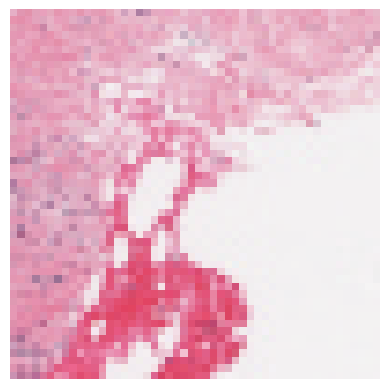

In [3]:
image_name = "D:/year_3/sem_2/Neural Networks/project/data/9135/1/9135_idx5_x1701_y1851_class1.png" #Image to be used as query
def plotImage(image_location):
    image = cv2.imread(image_name)
    image = cv2.resize(image, (50,50))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)); plt.axis('off')
    return
plotImage(image_name)

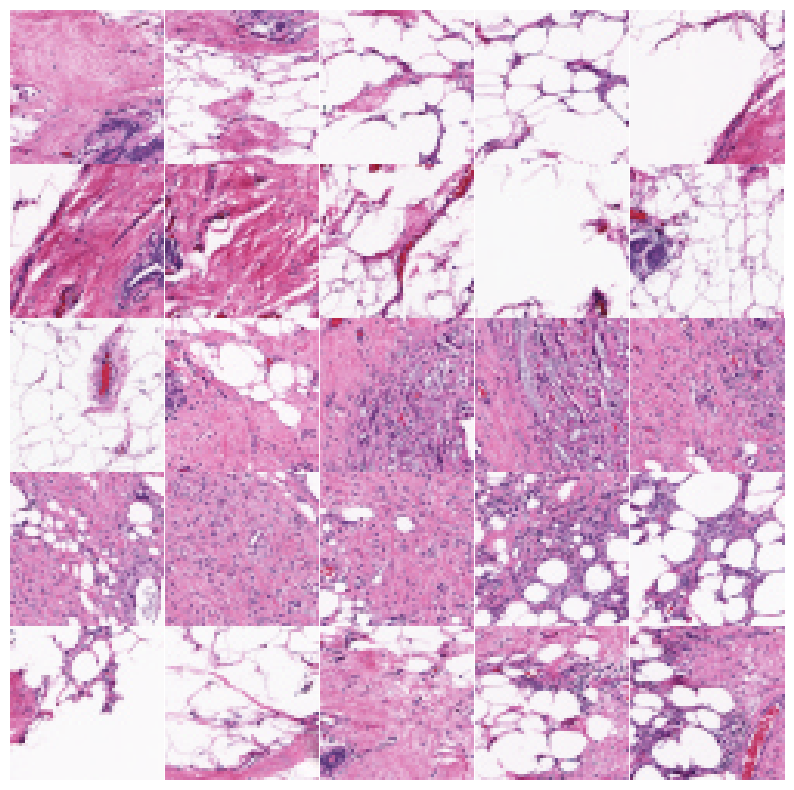

In [4]:
# Plot Multiple Images
bunchOfImages = imagePatches
i_ = 0
plt.rcParams['figure.figsize'] = (10.0, 10.0)
plt.subplots_adjust(wspace=0, hspace=0)
for l in bunchOfImages[:25]:
    im = cv2.imread(l)
    im = cv2.resize(im, (50, 50)) 
    plt.subplot(5, 5, i_+1) #.set_title(l)
    plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB)); plt.axis('off')
    i_ += 1

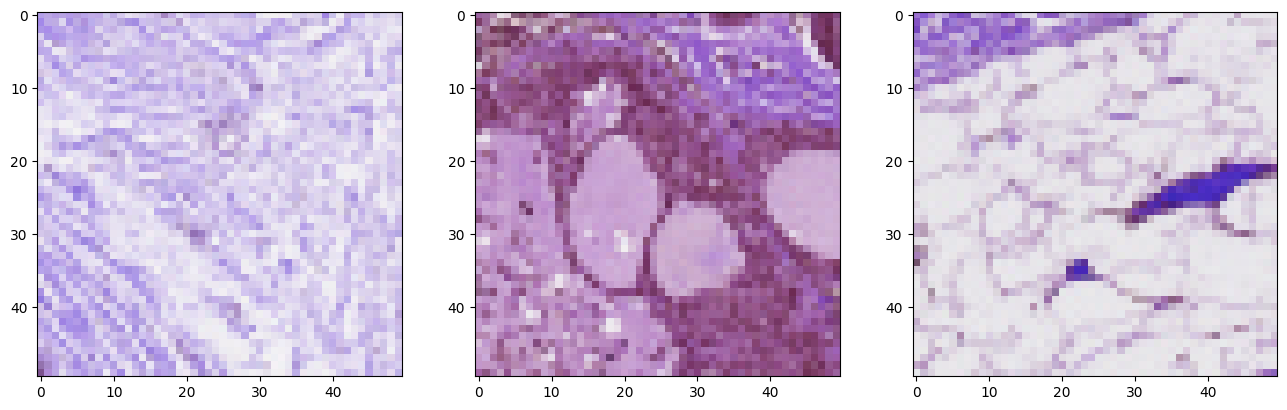

In [5]:
def randomImages(a):
    r = random.sample(a, 4)
    plt.figure(figsize=(16,16))
    plt.subplot(131)
    plt.imshow(cv2.imread(r[0]))
    plt.subplot(132)
    plt.imshow(cv2.imread(r[1]))
    plt.subplot(133)
    plt.imshow(cv2.imread(r[2])); 
randomImages(imagePatches)

In [6]:
patternZero = '*class0.png'
patternOne = '*class1.png'
classZero = fnmatch.filter(imagePatches, patternZero)
classOne = fnmatch.filter(imagePatches, patternOne)
print("IDC(-)\n\n",classZero[0:5],'\n')
print("IDC(+)\n\n",classOne[0:5])

IDC(-)

 ['D:/year_3/sem_2/Neural Networks/project/data\\10253\\0\\10253_idx5_x1001_y1001_class0.png', 'D:/year_3/sem_2/Neural Networks/project/data\\10253\\0\\10253_idx5_x1001_y1051_class0.png', 'D:/year_3/sem_2/Neural Networks/project/data\\10253\\0\\10253_idx5_x1001_y1101_class0.png', 'D:/year_3/sem_2/Neural Networks/project/data\\10253\\0\\10253_idx5_x1001_y1151_class0.png', 'D:/year_3/sem_2/Neural Networks/project/data\\10253\\0\\10253_idx5_x1001_y1201_class0.png'] 

IDC(+)

 ['D:/year_3/sem_2/Neural Networks/project/data\\10253\\1\\10253_idx5_x501_y351_class1.png', 'D:/year_3/sem_2/Neural Networks/project/data\\10253\\1\\10253_idx5_x501_y401_class1.png', 'D:/year_3/sem_2/Neural Networks/project/data\\10253\\1\\10253_idx5_x551_y301_class1.png', 'D:/year_3/sem_2/Neural Networks/project/data\\10253\\1\\10253_idx5_x551_y351_class1.png', 'D:/year_3/sem_2/Neural Networks/project/data\\10253\\1\\10253_idx5_x551_y401_class1.png']


In [7]:
def proc_images(lowerIndex,upperIndex):
    """
    Returns two arrays: 
        x is an array of resized images
        y is an array of labels
    """ 
    x = []
    y = []
    WIDTH = 50
    HEIGHT = 50
    for img in imagePatches[lowerIndex:upperIndex]:
        full_size_image = cv2.imread(img)
        x.append(cv2.resize(full_size_image, (WIDTH,HEIGHT), interpolation=cv2.INTER_CUBIC))
        if img in classZero:
            y.append(0)
        elif img in classOne:
            y.append(1)
        else:
            return
    return x,y

In [8]:
X, Y = proc_images(0, 90000)

# Create DataFrame
df = pd.DataFrame()
df["images"] = X
df["labels"] = Y

# Convert to numpy arrays
X2 = np.array(df["images"].tolist())
Y2 = np.array(df["labels"])

# Filter images based on labels
imgs0 = X2[Y2 == 0]  # Images with label 0
imgs1 = X2[Y2 == 1]  # Images with label 1

In [9]:
def describeData(a,b):
    print('Total number of images: {}'.format(len(a)))
    print('Number of IDC(-) Images: {}'.format(np.sum(b==0)))
    print('Number of IDC(+) Images: {}'.format(np.sum(b==1)))
    print('Percentage of positive images: {:.2f}%'.format(100*np.mean(b)))
    print('Image shape (Width, Height, Channels): {}'.format(a[0].shape))
describeData(X2,Y2)

Total number of images: 90000
Number of IDC(-) Images: 64583
Number of IDC(+) Images: 25417
Percentage of positive images: 28.24%
Image shape (Width, Height, Channels): (50, 50, 3)


In [10]:
# Print 5 random rows from the DataFrame
print(df.sample(n=5))

                                                  images  labels
26251  [[[137, 79, 134], [132, 78, 134], [214, 191, 2...       0
50473  [[[242, 241, 243], [242, 241, 243], [242, 241,...       0
37378  [[[222, 216, 225], [177, 137, 181], [169, 125,...       1
35970  [[[238, 231, 240], [197, 163, 209], [159, 124,...       0
37088  [[[199, 170, 211], [237, 235, 238], [239, 236,...       0


In [11]:
dict_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
print(df.head(10))
print("")
print(dict_characters)

                                              images  labels
0  [[[206, 164, 226], [196, 154, 224], [211, 175,...       0
1  [[[197, 150, 219], [201, 158, 217], [205, 173,...       0
2  [[[249, 245, 248], [248, 246, 248], [253, 246,...       0
3  [[[249, 247, 249], [249, 247, 249], [249, 247,...       0
4  [[[237, 231, 241], [245, 242, 246], [235, 222,...       0
5  [[[248, 246, 248], [248, 246, 248], [248, 246,...       0
6  [[[175, 120, 212], [145, 88, 175], [132, 72, 1...       0
7  [[[87, 38, 142], [120, 94, 165], [195, 180, 21...       0
8  [[[235, 228, 240], [242, 240, 246], [252, 244,...       0
9  [[[238, 223, 242], [239, 235, 241], [250, 245,...       0

{0: 'IDC(-)', 1: 'IDC(+)'}


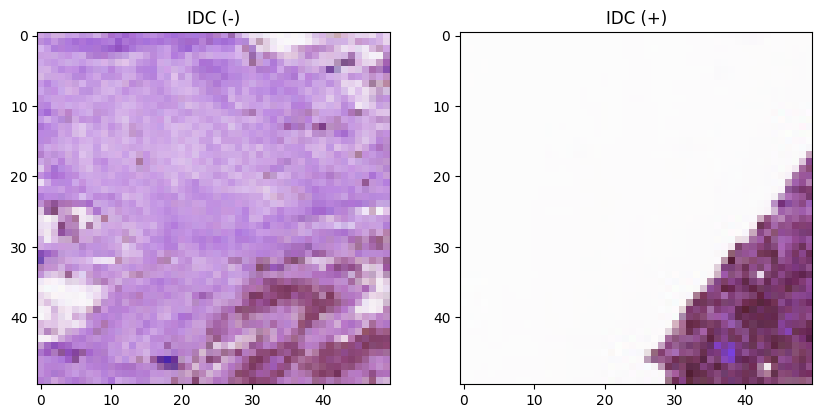

In [12]:
def plotOne(a,b):
    """
    Plot one numpy array
    """
    plt.subplot(1,2,1)
    plt.title('IDC (-)')
    plt.imshow(a[0])
    plt.subplot(1,2,2)
    plt.title('IDC (+)')
    plt.imshow(b[0])
plotOne(imgs0, imgs1) 

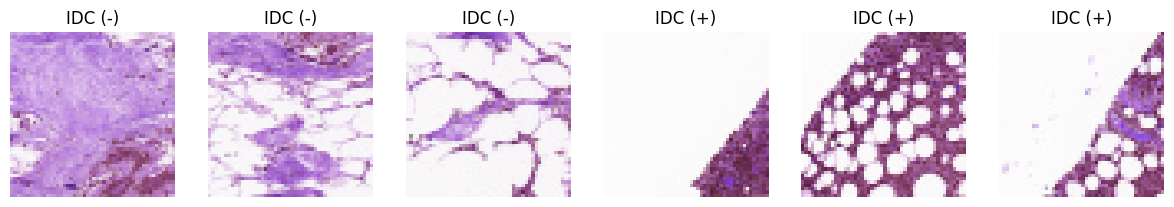

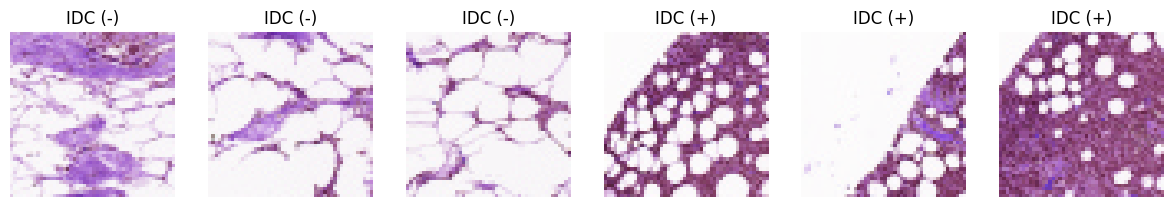

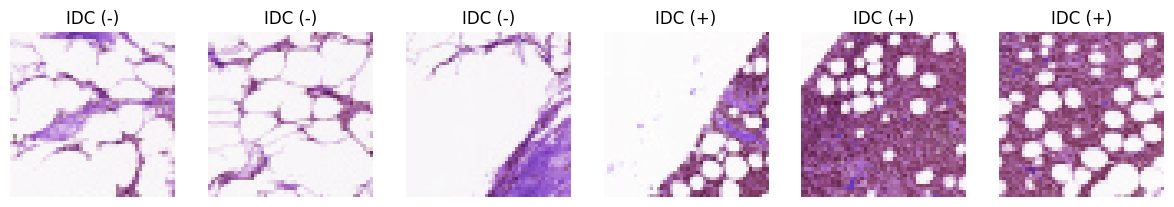

In [13]:
def plotTwo(a,b): 
    """
    Plot a bunch of numpy arrays sorted by label
    """
    for row in range(3):
        plt.figure(figsize=(20, 10))
        for col in range(3):
            plt.subplot(1,8,col+1)
            plt.title('IDC (-)')
            plt.imshow(a[0+row+col])
            plt.axis('off')       
            plt.subplot(1,8,col+4)
            plt.title('IDC (+)')
            plt.imshow(b[0+row+col])
            plt.axis('off')
plotTwo(imgs0, imgs1) 

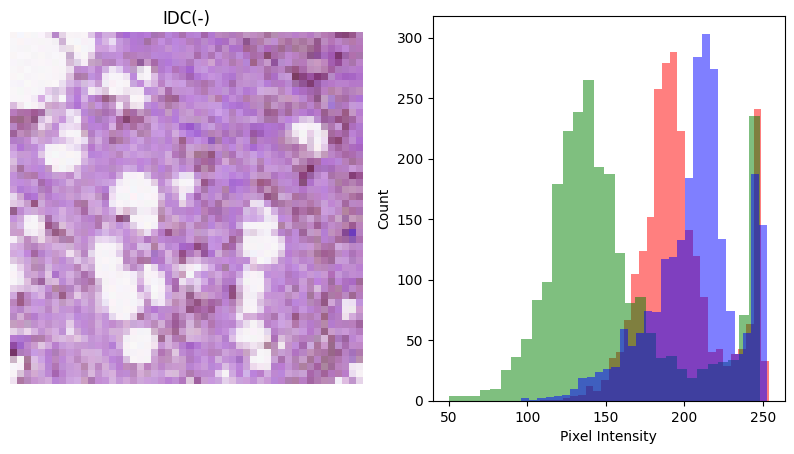

In [14]:
def plotHistogram(a):
    """
    Plot histogram of RGB Pixel Intensities
    """
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.imshow(a)
    plt.axis('off')
    plt.title('IDC(+)' if Y[1] else 'IDC(-)')
    histo = plt.subplot(1,2,2)
    histo.set_ylabel('Count')
    histo.set_xlabel('Pixel Intensity')
    n_bins = 30
    plt.hist(a[:,:,0].flatten(), bins= n_bins, lw = 0, color='r', alpha=0.5);
    plt.hist(a[:,:,1].flatten(), bins= n_bins, lw = 0, color='g', alpha=0.5);
    plt.hist(a[:,:,2].flatten(), bins= n_bins, lw = 0, color='b', alpha=0.5);
plotHistogram(X2[100])

In [15]:
X=np.array(X)
X=X/255.0

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2)

# Reduce Sample Size for DeBugging
X_train = X_train[0:200000] 
Y_train = Y_train[0:200000]
X_test = X_test[0:200000] 
Y_test = Y_test[0:200000]

print("Training Data Shape:", X_train.shape)
print("Testing Data Shape:", X_test.shape)

Training Data Shape: (72000, 50, 50, 3)
Testing Data Shape: (18000, 50, 50, 3)


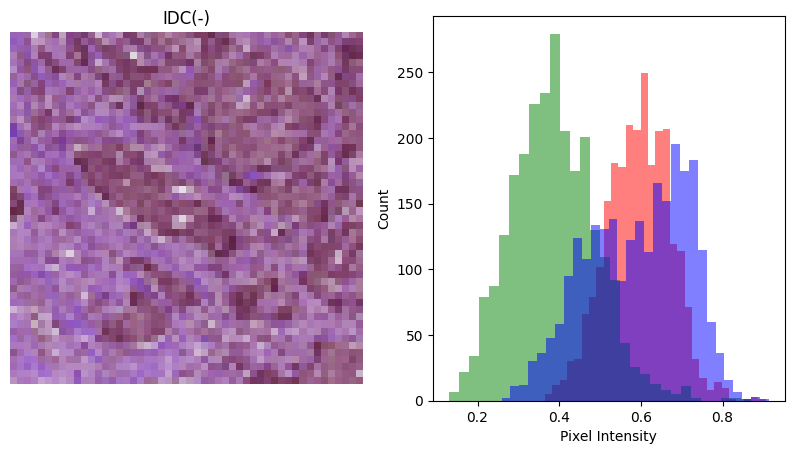

In [16]:
plotHistogram(X_train[100])

In [17]:
# Encode labels to hot vectors (ex : 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainHot = to_categorical(Y_train, num_classes = 2)
Y_testHot = to_categorical(Y_test, num_classes = 2)

In [18]:
lab = df['labels']
print(lab)
df['labels'].value_counts()

0        0
1        0
2        0
3        0
4        0
        ..
89995    0
89996    0
89997    0
89998    0
89999    0
Name: labels, Length: 90000, dtype: int64


labels
0    64583
1    25417
Name: count, dtype: int64

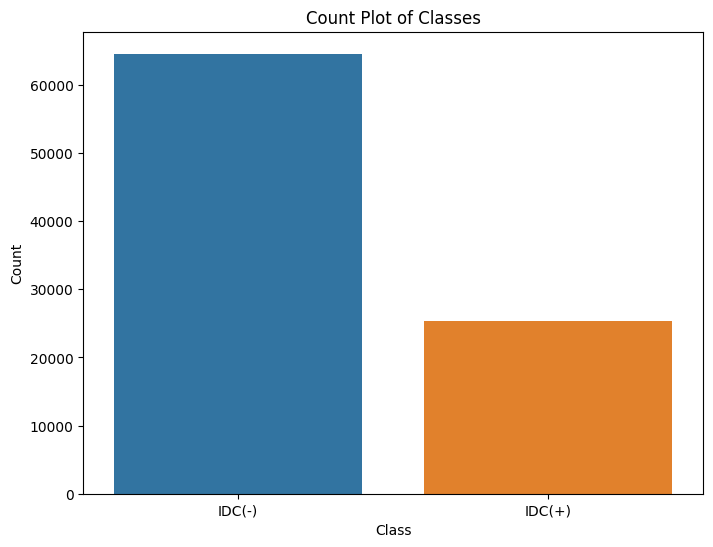

In [19]:
# Count the occurrences of each class
class_counts = df['labels'].value_counts()

# Plotting count plot for each class
plt.figure(figsize=(8, 6))
sns.countplot(x='labels', data=df)
plt.title('Count Plot of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['IDC(-)', 'IDC(+)'])
plt.show()

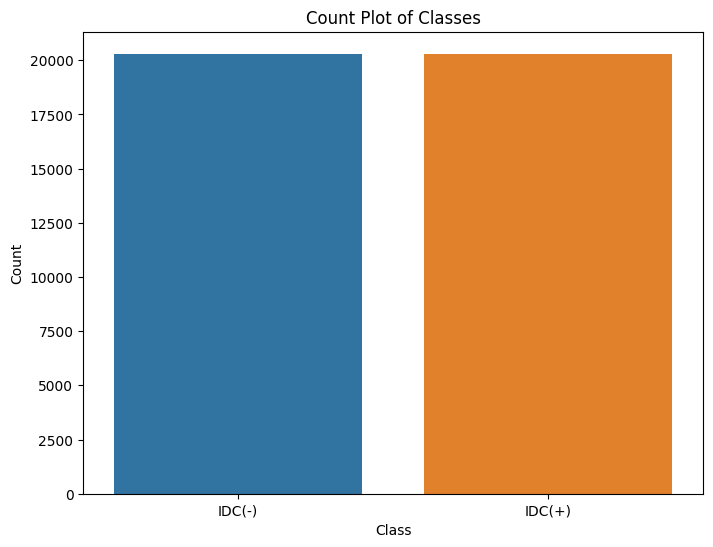

{0: 'IDC(-)', 1: 'IDC(+)'}


In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.utils import to_categorical

# Make Data 1D for compatibility with resampling methods
X_trainShape = X_train.shape[1]*X_train.shape[2]*X_train.shape[3]
X_testShape = X_test.shape[1]*X_test.shape[2]*X_test.shape[3]
X_trainFlat = X_train.reshape(X_train.shape[0], X_trainShape)
X_testFlat = X_test.reshape(X_test.shape[0], X_testShape)

# Initialize RandomUnderSampler with 'auto' strategy
ros = RandomUnderSampler(sampling_strategy='auto')
X_trainRos, Y_trainRos = ros.fit_resample(X_trainFlat, Y_train)
X_testRos, Y_testRos = ros.fit_resample(X_testFlat, Y_test)

# Encode labels to hot vectors (e.g., 2 -> [0,0,1,0,0,0,0,0,0,0])
Y_trainRosHot = to_categorical(Y_trainRos, num_classes = 2)
Y_testRosHot = to_categorical(Y_testRos, num_classes = 2)

# Reshape back to image dimensions
height, width, channels = 50, 50, 3
X_trainRosReshaped = X_trainRos.reshape(-1, height, width, channels)
X_testRosReshaped = X_testRos.reshape(-1, height, width, channels)

# Create DataFrame from labels
dfRos = pd.DataFrame()
dfRos["labels"] = Y_trainRos

# Count the occurrences of each class
distRos = dfRos['labels'].value_counts()

# Plotting count plot for each class
plt.figure(figsize=(8, 6))
sns.countplot(x='labels', data=dfRos)
plt.title('Count Plot of Classes')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['IDC(-)', 'IDC(+)'])
plt.show()

print(dict_characters)  # Print the dictionary of characters

In [21]:
# import numpy as np
# from sklearn.utils import class_weight as cw

# # Compute class weights for the original data
# old_class_weights = cw.compute_class_weight(class_weight='balanced', classes=np.unique(Y_train), y=Y_train)
# print("Old Class Weights: ", old_class_weights)

# # Compute class weights for the resampled data
# new_class_weights = cw.compute_class_weight(class_weight='balanced', classes=np.unique(Y_trainRos), y=Y_trainRos)
# print("New Class Weights: ", new_class_weights)


In [22]:
# from sklearn.utils import class_weight
# class_weight = class_weight.compute_class_weight('balanced', np.unique(Y_train), Y_train)
# print("Old Class Weights: ",class_weight)
# from sklearn.utils import class_weight
# class_weight2 = class_weight.compute_class_weight('balanced', np.unique(Y_trainRos), Y_trainRos)
# print("New Class Weights: ",class_weight2)

In [23]:
import numpy as np
from sklearn.utils import class_weight as cw

# Compute class weights for the original data
class_weight = cw.compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train)
print("Old Class Weights: ", class_weight)

# Compute class weights for the resampled data
class_weight2 = cw.compute_class_weight('balanced', classes=np.unique(Y_trainRos), y=Y_trainRos)
print("New Class Weights: ", class_weight2)


Old Class Weights:  [0.69632495 1.77339901]
New Class Weights:  [1. 1.]


In [24]:
print(cw)
print(class_weight)
print(class_weight2)

<module 'sklearn.utils.class_weight' from 'C:\\Users\\mezom\\anaconda3\\Lib\\site-packages\\sklearn\\utils\\class_weight.py'>
[0.69632495 1.77339901]
[1. 1.]


In [25]:
# Helper Functions  Learning Curves and Confusion Matrix

class MetricsCheckpoint(Callback):
    """Callback that saves metrics after each epoch"""
    def __init__(self, savepath):
        super(MetricsCheckpoint, self).__init__()
        self.savepath = savepath
        self.history = {}
    def on_epoch_end(self, epoch, logs=None):
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)
        np.save(self.savepath, self.history)

def plotKerasLearningCurve():
    plt.figure(figsize=(10,5))
    metrics = np.load('logs.npy')[()]
    filt = ['acc'] # try to add 'loss' to see the loss learning curve
    for k in filter(lambda x : np.any([kk in x for kk in filt]), metrics.keys()):
        l = np.array(metrics[k])
        plt.plot(l, c= 'r' if 'val' not in k else 'b', label='val' if 'val' in k else 'train')
        x = np.argmin(l) if 'loss' in k else np.argmax(l)
        y = l[x]
        plt.scatter(x,y, lw=0, alpha=0.25, s=100, c='r' if 'val' not in k else 'b')
        plt.text(x, y, '{} = {:.4f}'.format(x,y), size='15', color= 'r' if 'val' not in k else 'b')   
    plt.legend(loc=4)
    plt.axis([0, None, None, None]);
    plt.grid()
    plt.xlabel('Number of epochs')

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize = (5,5))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_learning_curve(history):
    plt.figure(figsize=(8,8))
    plt.subplot(1,2,1)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./accuracy_curve.png')
    #plt.clf()
    # summarize history for loss
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.savefig('./loss_curve.png')

In [26]:
def runKerasCNNAugment(a,b,c,d,e,class_weight):
    """
    Run Keras CNN: https://github.com/fchollet/keras/blob/master/examples/mnist_cnn.py
    """
    batch_size = 400
    num_classes = 2
    epochs = 8
#     img_rows, img_cols = a.shape[1],a.shape[2]
    img_rows,img_cols=50,50
    input_shape = (img_rows, img_cols, 3)
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3),
                     activation='relu',
                     input_shape=input_shape,strides=e))
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss=keras.losses.categorical_crossentropy,
                  optimizer=keras.optimizers.Adadelta(),
                  metrics=['accuracy'])
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True)  # randomly flip images
    history = model.fit_generator(datagen.flow(a,b, batch_size=32),
                        steps_per_epoch=len(a) / 32, epochs=epochs, validation_data = [c, d],callbacks = [MetricsCheckpoint('logs')])
    score = model.evaluate(c,d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1],'\n')
    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', sklearn.metrics.classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')    
    Y_pred_classes = np.argmax(y_pred,axis=1) 
    Y_true = np.argmax(d,axis=1) 
    plotKerasLearningCurve()
    plt.show()  
    plot_learning_curve(history)
    plt.show()
    confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
    plot_confusion_matrix(confusion_mtx, classes = list(dict_characters.values())) 
    plt.show()
runKerasCNNAugment(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot,2,class_weight2)

C:\Users\mezom\AppData\Local\Temp\ipykernel_16844\3399493468.py:36: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(datagen.flow(a,b, batch_size=32),


Epoch 1/8


1268/1268 [==============================] - 50s 38ms/step - loss: 0.7026 - accuracy: 0.5104 - val_loss: 0.6799 - val_accuracy: 0.5243
Epoch 2/8
1268/1268 [==============================] - 45s 36ms/step - loss: 0.6882 - accuracy: 0.5354 - val_loss: 0.6712 - val_accuracy: 0.5920
Epoch 3/8
1268/1268 [==============================] - 45s 36ms/step - loss: 0.6775 - accuracy: 0.5644 - val_loss: 0.6613 - val_accuracy: 0.6084
Epoch 4/8
1268/1268 [==============================] - 45s 36ms/step - loss: 0.6676 - accuracy: 0.5916 - val_loss: 0.6486 - val_accuracy: 0.6605
Epoch 5/8
1268/1268 [==============================] - 45s 35ms/step - loss: 0.6560 - accuracy: 0.6216 - val_loss: 0.6348 - val_accuracy: 0.6714
Epoch 6/8
1268/1268 [==============================] - 46s 36ms/step - loss: 0.6444 - accuracy: 0.6419 - val_loss: 0.6228 - val_accuracy: 0.6916
Epoch 7/8
1268/1268 [==============================] - 45s 36ms/step - loss: 0.6305 - accuracy: 0.6608 - val_loss: 0.6095 - val_

ValueError: Object arrays cannot be loaded when allow_pickle=False

<Figure size 1000x500 with 0 Axes>

In [27]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adadelta
from sklearn.metrics import classification_report, confusion_matrix

def runKerasCNNAugment(a, b, c, d, e, class_weight):
    batch_size = 128
    num_classes = 2
    epochs = 8
    img_rows, img_cols = 50, 50
    input_shape = (img_rows, img_cols, 3)

    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, strides=e),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adadelta(learning_rate=1.0),
                  metrics=['accuracy'])

    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        horizontal_flip=True,
        vertical_flip=True
    )

    # Ensure class_weight is a dictionary
    if isinstance(class_weight, (list, np.ndarray)):
        class_weight_dict = {i: weight for i, weight in enumerate(class_weight)}
    else:
        class_weight_dict = class_weight

    history = model.fit(
        datagen.flow(a, b, batch_size=32),
        steps_per_epoch=len(a) / 32, 
        epochs=epochs, 
        validation_data=[c, d],
        class_weight=class_weight_dict
    )

    score = model.evaluate(c, d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1], '\n')

    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')

# Example function call
runKerasCNNAugment(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot, 2, class_weight2)


Epoch 1/8
1268/1268 [==============================] - 52s 39ms/step - loss: 0.5159 - accuracy: 0.7801 - val_loss: 0.8100 - val_accuracy: 0.6871
Epoch 2/8
1268/1268 [==============================] - 48s 38ms/step - loss: 0.4423 - accuracy: 0.8100 - val_loss: 0.8531 - val_accuracy: 0.7035
Epoch 3/8
1268/1268 [==============================] - 49s 38ms/step - loss: 0.4291 - accuracy: 0.8135 - val_loss: 0.4967 - val_accuracy: 0.7917
Epoch 4/8
1268/1268 [==============================] - 48s 38ms/step - loss: 0.4193 - accuracy: 0.8198 - val_loss: 0.4295 - val_accuracy: 0.8106
Epoch 5/8
1268/1268 [==============================] - 48s 38ms/step - loss: 0.4157 - accuracy: 0.8226 - val_loss: 0.5303 - val_accuracy: 0.7541
Epoch 6/8
1268/1268 [==============================] - 48s 38ms/step - loss: 0.4102 - accuracy: 0.8235 - val_loss: 0.4968 - val_accuracy: 0.7636
Epoch 7/8
1268/1268 [==============================] - 48s 38ms/step - loss: 0.4054 - accuracy: 0.8268 - val_loss: 0.4610 - val_ac

In [28]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adadelta
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn.metrics import classification_report, confusion_matrix

def runKerasCNNAugment(a, b, c, d, e, class_weight):
    batch_size = 128
    num_classes = 2
    epochs = 8
    img_rows, img_cols = 50, 50
    input_shape = (img_rows, img_cols, 3)

    model = Sequential([
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape, strides=e),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.35),

        Conv2D(128, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.35),

        Conv2D(256, (3, 3), activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.35),

        Flatten(),
        Dense(256, activation='relu', kernel_regularizer=l2(0.01)),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])

    model.compile(loss='categorical_crossentropy',
                  optimizer=Adadelta(learning_rate=1.0),
                  metrics=['accuracy'])

    datagen = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=25,  # Increased variability
        width_shift_range=0.3,  # Increased variability
        height_shift_range=0.3,  # Increased variability
        horizontal_flip=True,
        vertical_flip=True
    )

    # Early stopping to prevent overfitting
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

    # Ensure class_weight is a dictionary
    if isinstance(class_weight, (list, np.ndarray)):
        class_weight_dict = {i: weight for i, weight in enumerate(class_weight)}
    else:
        class_weight_dict = class_weight

    history = model.fit(
        datagen.flow(a, b, batch_size=32),
        steps_per_epoch=len(a) / 32, 
        epochs=epochs, 
        validation_data=[c, d],
        class_weight=class_weight_dict,
        callbacks=[early_stopping]
    )

    score = model.evaluate(c, d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1], '\n')

    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')

# Example function call
runKerasCNNAugment(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot, 2, class_weight2)


Epoch 1/8
1268/1268 [==============================] - 52s 40ms/step - loss: 0.9830 - accuracy: 0.7799 - val_loss: 0.6325 - val_accuracy: 0.6732
Epoch 2/8
1268/1268 [==============================] - 52s 41ms/step - loss: 0.4592 - accuracy: 0.8090 - val_loss: 0.4648 - val_accuracy: 0.8030
Epoch 3/8
1268/1268 [==============================] - 49s 38ms/step - loss: 0.4501 - accuracy: 0.8122 - val_loss: 0.4479 - val_accuracy: 0.8269
Epoch 4/8
1268/1268 [==============================] - 49s 39ms/step - loss: 0.4420 - accuracy: 0.8143 - val_loss: 0.4357 - val_accuracy: 0.8139
Epoch 5/8
1268/1268 [==============================] - 52s 41ms/step - loss: 0.4339 - accuracy: 0.8200 - val_loss: 0.4926 - val_accuracy: 0.7749
Epoch 6/8
1268/1268 [==============================] - 49s 39ms/step - loss: 0.4281 - accuracy: 0.8225 - val_loss: 0.8548 - val_accuracy: 0.7393
Epoch 7/8
1268/1268 [==============================] - 49s 39ms/step - loss: 0.4271 - accuracy: 0.8220 - val_loss: 0.4483 - val_ac

In [29]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix

def runKerasCNNAugment(a, b, c, d, e, class_weight):
    num_classes = 2
    epochs = 8
    img_rows, img_cols = 50, 50  # Ensure your images are resized to match VGG16's input

    # Load VGG16 without the top layer and freeze the pretrained layers
    base_model = VGG16(include_top=False, weights='imagenet', input_tensor=Input(shape=(img_rows, img_cols, 3)))
    for layer in base_model.layers:
        layer.trainable = False

    # Add new layers
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)

    # Create new model
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

    # Data augmentation
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    # Early stopping and checkpointing
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
    checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

    # Ensure class_weight is a dictionary
    if isinstance(class_weight, (list, np.ndarray)):
        class_weight_dict = {i: weight for i, weight in enumerate(class_weight)}
    else:
        class_weight_dict = class_weight

    # Fit the model
    history = model.fit(
        datagen.flow(a, b, batch_size=32),
        steps_per_epoch=len(a) / 32,
        epochs=epochs,
        validation_data=[c, d],
        class_weight=class_weight_dict,
        callbacks=[early_stopping, checkpoint]
    )

    score = model.evaluate(c, d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1], '\n')

    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')

# Call the function with correct inputs
runKerasCNNAugment(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot, 2, class_weight2)


Epoch 1/8
1268/1268 [==============================] - 254s 199ms/step - loss: 1.6127 - accuracy: 0.7047 - val_loss: 0.7659 - val_accuracy: 0.7672
Epoch 2/8


C:\Users\mezom\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1268/1268 [==============================] - 248s 195ms/step - loss: 0.6905 - accuracy: 0.7527 - val_loss: 0.6173 - val_accuracy: 0.7628
Epoch 3/8
1268/1268 [==============================] - 252s 199ms/step - loss: 0.6038 - accuracy: 0.7591 - val_loss: 0.5746 - val_accuracy: 0.7645
Epoch 4/8
1268/1268 [==============================] - 270s 213ms/step - loss: 0.5694 - accuracy: 0.7601 - val_loss: 0.5494 - val_accuracy: 0.7674
Epoch 5/8
1268/1268 [==============================] - 281s 221ms/step - loss: 0.5560 - accuracy: 0.7618 - val_loss: 0.5430 - val_accuracy: 0.7613
Epoch 6/8
1268/1268 [==============================] - 282s 222ms/step - loss: 0.5433 - accuracy: 0.7640 - val_loss: 0.5290 - val_accuracy: 0.7676
Epoch 7/8
1268/1268 [==============================] - 276s 217ms/step - loss: 0.5366 - accuracy: 0.7634 - val_loss: 0.5179 - val_accuracy: 0.7765
Epoch 8/8
1268/1268 [==============================] - 274s 216ms/step - loss: 0.5307 - accuracy: 0.7677 - val_loss: 0.5219 - va

In [30]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.regularizers import l2
from keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix

def runKerasCNNAugment(a, b, c, d, e, class_weight):
    num_classes = 2
    epochs = 8
    img_rows, img_cols = 50, 50  # Ensure your images are resized to match VGG16's input

    # Load VGG16 without the top layer and freeze the pretrained layers
    base_model = VGG16(include_top=False, weights='imagenet', input_tensor=Input(shape=(img_rows, img_cols, 3)))
    for layer in base_model.layers:
        layer.trainable = False

    # Add new layers
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)

    # Create new model
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

    # Data augmentation
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    # Early stopping and checkpointing
    early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)
    checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

    # Ensure class_weight is a dictionary
    if isinstance(class_weight, (list, np.ndarray)):
        class_weight_dict = {i: weight for i, weight in enumerate(class_weight)}
    else:
        class_weight_dict = class_weight

    # Fit the model
    history = model.fit(
        datagen.flow(a, b, batch_size=32),
        steps_per_epoch=len(a) / 32,
        epochs=epochs,
        validation_data=[c, d],
        class_weight=class_weight_dict,
        callbacks=[early_stopping, checkpoint]
    )

    score = model.evaluate(c, d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1], '\n')

    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')

# Call the function with correct inputs
runKerasCNNAugment(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot, 2, class_weight2)


Epoch 1/8
1268/1268 [==============================] - 274s 215ms/step - loss: 0.7125 - accuracy: 0.7347 - val_loss: 0.5410 - val_accuracy: 0.7579
Epoch 2/8


C:\Users\mezom\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


1268/1268 [==============================] - 274s 216ms/step - loss: 0.5650 - accuracy: 0.7437 - val_loss: 0.5376 - val_accuracy: 0.7640
Epoch 3/8
1268/1268 [==============================] - 274s 216ms/step - loss: 0.5607 - accuracy: 0.7456 - val_loss: 0.5216 - val_accuracy: 0.7757
Epoch 4/8
1268/1268 [==============================] - 276s 217ms/step - loss: 0.5587 - accuracy: 0.7442 - val_loss: 0.5293 - val_accuracy: 0.7656
Epoch 5/8
1268/1268 [==============================] - 297s 234ms/step - loss: 0.5550 - accuracy: 0.7493 - val_loss: 0.5207 - val_accuracy: 0.7639
Epoch 6/8
1268/1268 [==============================] - 317s 250ms/step - loss: 0.5519 - accuracy: 0.7498 - val_loss: 0.5168 - val_accuracy: 0.7725
Epoch 7/8
1268/1268 [==============================] - 291s 229ms/step - loss: 0.5544 - accuracy: 0.7475 - val_loss: 0.5184 - val_accuracy: 0.7670
Epoch 8/8
1268/1268 [==============================] - 295s 232ms/step - loss: 0.5556 - accuracy: 0.7444 - val_loss: 0.5428 - va

In [31]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.applications.vgg16 import VGG16
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler
from keras.regularizers import l2
from keras.models import Model
from sklearn.metrics import classification_report, confusion_matrix
import math

def step_decay(epoch):
    initial_lrate = 0.0001
    drop = 0.5
    epochs_drop = 10.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    return lrate

def runKerasCNNAugment(a, b, c, d, e, class_weight):
    num_classes = 2
    epochs = 20  # Increased epochs for potential fine-tuning and further training
    img_rows, img_cols = 50, 50  # Adjust based on your dataset or VGG16 requirement
    
    # Load VGG16 without the top layer
    base_model = VGG16(include_top=False, weights='imagenet', input_tensor=Input(shape=(img_rows, img_cols, 3)))
    
    # Freeze the layers of the base model initially
    for layer in base_model.layers:
        layer.trainable = False
    
    # Adding custom layers on top of VGG16
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = Dense(num_classes, activation='softmax')(x)

    # Final model setup
    model = Model(inputs=base_model.input, outputs=x)
    model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['accuracy'])

    # Enhanced data augmentation
    datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='nearest'
    )

    # Convert class_weight to dictionary if it is not already
    if isinstance(class_weight, (list, np.ndarray)):
        class_weight_dict = {i: weight for i, weight in enumerate(class_weight)}
    else:
        class_weight_dict = class_weight

    # Callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, restore_best_weights=True)
    checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, mode='min')
    lrate = LearningRateScheduler(step_decay)

    # Fit the model
    history = model.fit(
        datagen.flow(a, b, batch_size=32),
        steps_per_epoch=len(a) / 32, 
        epochs=epochs, 
        validation_data=[c, d],
        class_weight=class_weight_dict,
        callbacks=[checkpoint, early_stopping, lrate]
    )

    # Evaluate the model
    score = model.evaluate(c, d, verbose=0)
    print('\nKeras CNN #1C - accuracy:', score[1], '\n')

    y_pred = model.predict(c)
    map_characters = {0: 'IDC(-)', 1: 'IDC(+)'}
    print('\n', classification_report(np.where(d > 0)[1], np.argmax(y_pred, axis=1), target_names=list(map_characters.values())), sep='')

# Example function call
# Make sure to define 'X_trainRosReshaped', 'Y_trainRosHot', 'X_testRosReshaped', 'Y_testRosHot', and 'class_weight2' correctly.
runKerasCNNAugment(X_trainRosReshaped, Y_trainRosHot, X_testRosReshaped, Y_testRosHot, 2, class_weight2)


Epoch 1/20
1268/1268 [==============================] - 296s 233ms/step - loss: 1.6175 - accuracy: 0.7107 - val_loss: 0.7834 - val_accuracy: 0.7575 - lr: 1.0000e-04


C:\Users\mezom\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


Epoch 2/20
1268/1268 [==============================] - 298s 235ms/step - loss: 0.6971 - accuracy: 0.7508 - val_loss: 0.6204 - val_accuracy: 0.7673 - lr: 1.0000e-04
Epoch 3/20
1268/1268 [==============================] - 296s 233ms/step - loss: 0.6089 - accuracy: 0.7571 - val_loss: 0.5759 - val_accuracy: 0.7635 - lr: 1.0000e-04
Epoch 4/20
1268/1268 [==============================] - 264s 208ms/step - loss: 0.5714 - accuracy: 0.7612 - val_loss: 0.5535 - val_accuracy: 0.7619 - lr: 1.0000e-04
Epoch 5/20
1268/1268 [==============================] - 262s 206ms/step - loss: 0.5548 - accuracy: 0.7620 - val_loss: 0.5335 - val_accuracy: 0.7708 - lr: 1.0000e-04
Epoch 6/20
1268/1268 [==============================] - 262s 206ms/step - loss: 0.5426 - accuracy: 0.7651 - val_loss: 0.5305 - val_accuracy: 0.7669 - lr: 1.0000e-04
Epoch 7/20
1268/1268 [==============================] - 258s 203ms/step - loss: 0.5362 - accuracy: 0.7666 - val_loss: 0.5255 - val_accuracy: 0.7665 - lr: 1.0000e-04
Epoch 8/20